<a href="https://colab.research.google.com/github/sirunde/FaceRecognition/blob/master/assignment_3_Park_B00977950.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
**Due December 13th, 11:59 PM**

GitHub Classroom assignment link: https://classroom.github.com/a/p0lgkpDj.

Instructions for how to connect your Google Colab to GitHub are [here](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb).

Name: \<Jiyun Park\><br>
B-Number: \<B0089770950<br>
Email: \<qkrwldbs1216@gmail.com\>

In the following assignment, you will be using the deep learning framework, PyTorch, to perform computer vision tasks such as image classification and object detection. This will be a report-style assignment, where you will try multiple different models, optimization algorithms, and hyperparameters, and present your findings in a short report with visualizations inside the notebook.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section.

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells.

Cells marked **run** need to be run to set up the appropriate infrastructure, but do not need to be modified. Make sure you have run the previous cells before running the current cell, or you may get an error.

It is standard practice in ML to share notebooks to discuss the workflow and results in a professional setting. So, the code quality also matters. You should make sure your code is readable and conforms to standard practices. Your figures should be intelligable and include proper axis labels, titles, and legends. Unreadable and poorly written code may result in a points deduction.  

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**

## Uploading and Downloading Data from Colab

Unlike the previous assignments, you will downloading and uploading additional data from and into the Colab environment.

You can mount directories from your Google Drive and use the session storage for your work.

[Take a look here for an example notebook on handling data download and upload on Colab. ](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh)

## Import statements

**Run** the cell to import the packages needed for the code below. You may other packages but ask first.

In [1]:
import torch
import csv
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
torch.manual_seed(42)  # Set the seed for the random number generator

## CUDA Runtime

You will want to make use of the GPU runtimes on Colab to speed up your training. You can change your runtime by going to:

`Runtime > Change runtime type` and selecting GPU.

You will have to explicitly use the send Torch tensors to GPUs, by calling `.cuda()`  on the tensors and modules to utilize them on the GPU.

[Take a look at the quickstart for PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

## Part 1: Data Handling in PyTorch (20 pts)

### Dataset class

A large part of any machine learning workflow is the proper and efficient handling of data. Datasets are often large, scattered across filesystems, and require transformations and augmentation. Deep learning libraries such as `PyTorch` provide utilities to help in this process. In the next section, you will write a custom MNIST dataset and add data augmentation to your data pipeline for your traininig.

**Run** the following cell to define some helper functions to load the MNIST data.

In [4]:
def _data_parser_helper(csv_file_name):
  '''
  Reads CSV file and converts it into numpy arrays.

  Args:
    csv_file_name (string): String of the path of csv file.

  Returns:
    (np.array(float), np.array(int)): Returns a tuple of numpy arrays.
  '''
  X = []
  Y = []
  with open(csv_file_name,'r') as _file:
      csv_reader = csv.reader(_file, delimiter=",")
      for row in csv_reader:
          Y.append(int(row[0]))
          X.append([float(i)/255.0 for i in row[1:]])
  return (np.array(X), np.array(Y))

def get_mnist_train_data():
  X_train, Y_train = _data_parser_helper("sample_data/mnist_train_small.csv")
  return X_train, Y_train

def get_mnist_test_data():
  X_test, Y_test = _data_parser_helper("sample_data/mnist_test.csv")
  return X_test, Y_test

***Implement*** the `MNIST` class to serve as a container for our PyTorch MNIST data. [Take a look at this tutorial on PyTorch datasets, dataloading, and transforms.](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
[This second, more important tutorial specifically covers custom datasets and dataloaders.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

The MNIST data on Colab is pre-installed on all notebooks as a CSV.
Your class must read the data and store it as PyTorch float tensors.
Use the helper functions above (already written) to read the data,
which will return the data as NumPy arrays.

You should implement:

- `__init__()` to read the appropriate CSV file, and store it in the class as a `torch.Tensor` with float dtype.
- `__len__()` to return the number of samples in the dataset.
- `__getitem__(i)` to return the i-th sample and label from the data you have stored.

In [5]:
class MNIST(Dataset):
  """MNIST custom dataset that reads the CSV file and transforms them into PyTorch Tensors"""


  def __init__(self, is_training=True, transform=None):
    """
    Args:
      is_training (bool): If true loads
        the training dataset. If false, loads the test dataset.
        Use the functions above.
      transform (callable): Transform to be applied on a sample.
        These will be used for data augmentations.
    """
    super().__init__()

    self._data, self._label = get_mnist_train_data()

    self._data = torch.from_numpy(self._data.reshape((20000, 1, 28, 28)))
    self._label = torch.from_numpy(self._label)
    self.transform = transform


  def __len__(self):
    """Returns the size (the number of samples) of the dataset.
    """

    # raise NotImplementedError("The __len__() method was not implemented.")
    return self._data.shape[0]

  def __getitem__(self, i):
    """Returns the i-th sample and label and applies any transforms defined.

      Args:
        i (int): The index of sample in the data array to retrieve.
    """

    # return NotImplementedError("The __getitem__() method was not implemented")

    sample = self._data[i]
    label = self._label[i]
    if (self.transform):
      sample = self.transform(sample)
    return sample, label

In [6]:
composed = transforms.Compose([transforms.RandomRotation(15)])
mnist_dataset = MNIST(transform=composed)

In [7]:
from time import perf_counter

In [8]:
loader = DataLoader(mnist_dataset, batch_size=512, num_workers=2)

In [9]:
start = perf_counter()
for _data, label in loader:
  x = _data.shape[0]
end = perf_counter()

In [10]:
print(end-start)

8.922912464000092


***Implement*** the following cell to visualize the data in the dataset. Use `Matplotlib` or your favorite visualization package to plot 5 images of each class in a single figure.

You should initialize a MNIST dataset object for the training class. Visualize this dataset. This will not be used in the future.  



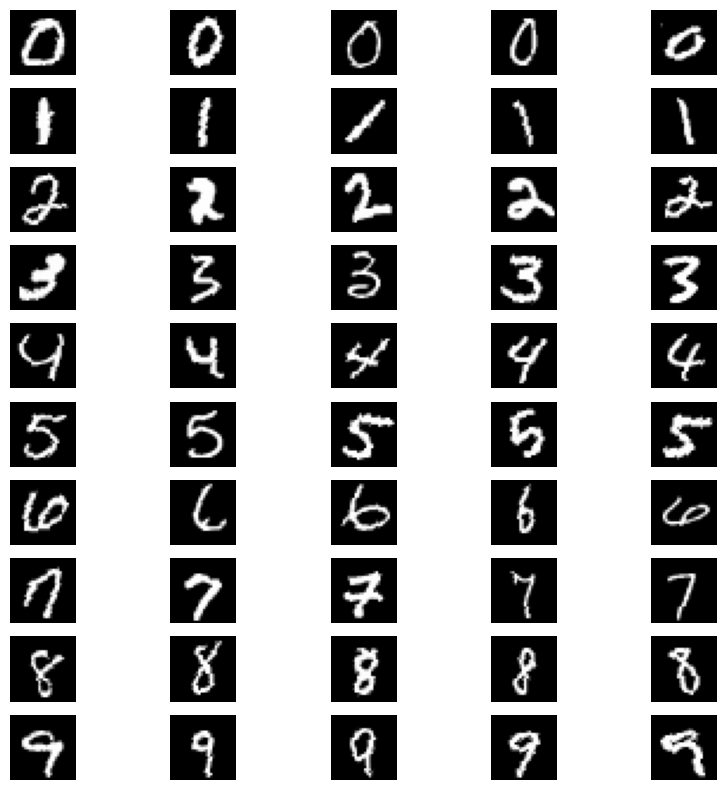

In [ ]:

# Create a figure with subplots
fig, axes = plt.subplots(10, 5, figsize=(10, 10))

# Iterate through classes and plot images
for class_label in range(10):
    class_indices = torch.where(mnist_dataset._label == class_label)[0]
    for i in range(5):
        if i < len(class_indices):
            image_index = class_indices[i]
            image = mnist_dataset[image_index][0].squeeze(0).numpy() # remove channel dimension and convert to numpy
            axes[class_label, i].imshow(image, cmap='gray')
            axes[class_label, i].axis('off')
            if i == 0:
              axes[class_label, i].set_ylabel(f"Class {class_label}")
        else:
            axes[class_label, i].axis('off')
plt.show()

***Implement***
the following cell to create a PyTorch transform object and
assign it to a variable.
You may name the variable whatever you wish;
you will use the object to construct train and test MNIST datasets.

You will use the transformations defined in `torchvision`,
which can be found [here](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor).

Add the `RandomRotation` and `Normalize` transformations to the dataset. You will need to [compose the two transforms](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose). Restrict the rotations to +/- 15 degrees.

The mean and standard deviation of the training set is 0.13 and 0.31 respectively.

At the end of the cell, construct a training and test dataset.
Name these carefully, these datasets will be used in the next sections.

In [11]:
transform  = transforms.Compose([
    # transforms.ToTensor(),
    transforms.RandomRotation(degrees = (15)),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

mnist_train = MNIST(is_training=True, transform=transform)
mnist_test = MNIST(is_training=False, transform=transform)

***Implement*** the following cell to visualize the data in the dataset with the transformations similar to the previous visualization.

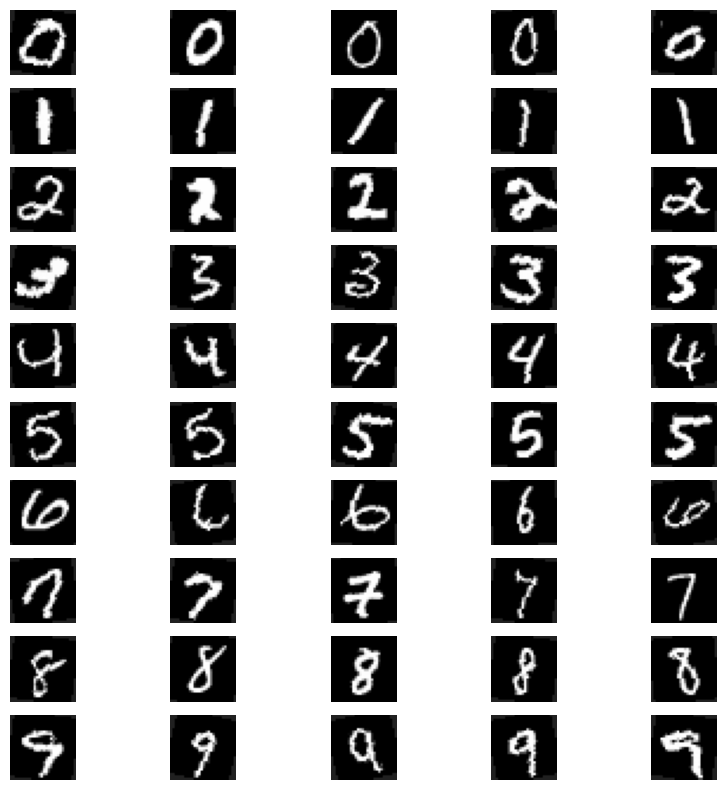

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(10, 5, figsize=(10, 10))

# Iterate through classes and plot images
for class_label in range(10):
    class_indices = torch.where(mnist_train._label == class_label)[0]
    for i in range(5):
        if i < len(class_indices):
            image_index = class_indices[i]
            img = mnist_train[image_index][0].squeeze(0).numpy()
            axes[class_label, i].imshow(img, cmap='gray')
            axes[class_label, i].axis('off')

plt.show()

***Implement*** the following cell to randomly split the training dataset previously defined, and make a training and validation set. Do an 80-20 split for the training and validation set. Name these sets carefully, they will be used in the next section to train your models.

You can use the utilities in `torch.utils.data`.

In [12]:
from torch.utils.data import random_split
train_len = int(0.8 * len(mnist_train))
val_len = len(mnist_train) - train_len
train_set, val_set = random_split(mnist_train, [train_len, val_len])

## Part 2: MNIST Classification (40 pts)

### Linear Classifiers

The linear classifiers you implemented in the last assignment will serve as our baseline for more powerful convolutional neural networks. You will ***implement*** the multi-class SVM and  Softmax classifiers in the following cells.  

**Implement** a LinearSVM classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`.

You should use classes and functions defined in `torch.nn` and `torch.nn.Functional`.   

In [13]:
class LinearSVM(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''

  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__()
    self.fc = nn.Linear(28*28, num_classes)
    self.relu = nn.ReLU()
    self.num_classes = num_classes

    # raise NotImplementedError("LinearSVM forward not implemented")


  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor.
    '''
    # raise NotImplementedError("LinearSVM forward not implemented")
    x = x.to(torch.float32)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

  def hinge_loss(self, output, labels):
    loss = 0
    margin = 1

    num_classes = output.size(1)
    labels_one_hot = torch.zeros_like(output).to(output.device)
    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)

    # Compute the correct class scores
    correct_class_scores = (labels_one_hot * output).sum(dim=1, keepdim=True)  # Keep the dimension

    # Compute the hinge loss
    margin_loss = torch.max(torch.zeros_like(output),
                            output - correct_class_scores + margin)  # Broadcast correctly

    # Remove correct class score from the margin loss (optional)
    # and average over the batch
    hinge_loss = margin_loss.sum() / output.size(0)

    return hinge_loss

***Implement*** using any PyTorch defined optimizer, code to train your LinearSVM classifier on the training dataset. You will want to try different optimizers, learning rates, and batch sizes.

PyTorch provides implementations of various optimization algorithms in the `torch.optim` package. You can use any of the first order methods such as:

- SGD (with or without momentum)
- AdaDelta
- ADAM
- RProp
- RMSProp

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You should use `Torch.utils.data.DataLoader` to do the data loading. Make sure to use the correct loss function. You may use the predefined loss functions available in `Torch.nn`.

***Note:*** As the optimization procedure for training different models is often the same, you should write helper functions that are reusable. This will make your code more readable and reduce the possibility of unexpected bugs.  

To train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [14]:
learning = [1e-5,1e-4,1e-3]
loss_fn = nn.CrossEntropyLoss()
models = []
trainloader = DataLoader(train_set, batch_size=500)
valloader = DataLoader(val_set, batch_size=500)

def train(model, loss_fn, optimizer):
  trainsize = len(trainloader.dataset)
  valsize = len(trainloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(trainloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = model.hinge_loss(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{trainsize:>5d}]")

  model.eval()  # Set model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  print(f"accuracy: {accuracy}")

for i in learning:
  print(f"lr:{i}")


  print("SGD")
  model = LinearSVM(num_classes=10).to(device)
  optimizerSGD = torch.optim.SGD(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerSGD)
  models.append(model)

  print("ADA")
  model = LinearSVM(num_classes=10).to(device)
  optimizerAda = torch.optim.Adadelta(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerAda)
  models.append(model)

  print("ADAM")
  model = LinearSVM(num_classes=10).to(device)
  optimizerADAM = torch.optim.Adam(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerADAM)
  models.append(model)

  print("RPROP")
  model = LinearSVM(num_classes=10).to(device)
  optimizerRProp = torch.optim.Rprop(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerRProp)
  models.append(model)




lr:1e-05
SGD
loss: 10.284714  [  500/16000]
accuracy: 11.425
ADA
loss: 9.753649  [  500/16000]
accuracy: 11.75
ADAM
loss: 10.780268  [  500/16000]
accuracy: 11.025
RPROP
loss: 10.952917  [  500/16000]
accuracy: 70.025
lr:0.0001
SGD
loss: 10.665602  [  500/16000]
accuracy: 23.1
ADA
loss: 11.066937  [  500/16000]
accuracy: 5.2
ADAM
loss: 10.829715  [  500/16000]
accuracy: 32.6
RPROP
loss: 10.362964  [  500/16000]
accuracy: 84.0
lr:0.001
SGD
loss: 9.669214  [  500/16000]
accuracy: 71.35
ADA
loss: 11.280649  [  500/16000]
accuracy: 7.075
ADAM
loss: 11.251436  [  500/16000]
accuracy: 81.2
RPROP
loss: 10.457325  [  500/16000]
accuracy: 85.55


**Implement** a Softmax classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`.

In [22]:
class Softmax(nn.Module):

  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__()
    self.num_classes = num_classes
    self.fc = nn.Linear(28*28, num_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    # raise NotImplementedError("LinearSVM forward not implemented")


  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor.
    '''
    # raise NotImplementedError("LinearSVM forward not implemented")
    x = x.to(torch.float32)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    x = self.relu(x)
    x = self.softmax(x)
    return x

***Implement*** using any PyTorch defined optimizer, train your Softmax classifier on the training dataset and validate on the validation dataset, as you did before.

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You will want to try different optimizers, learning rates, and batch sizes. You should use `Torch.DataLoader` to simplify the data loading. Make sure to use the correct loss function. You may use predefined loss functions available in `Torch.nn`.

Same as before, to train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [23]:
learning = [1e-5,1e-4,1e-3]
loss_fn = nn.CrossEntropyLoss()
sftmodels = []
trainloader = DataLoader(train_set, batch_size=500)
valloader = DataLoader(val_set, batch_size=500)

def train(model, loss_fn, optimizer):
  trainsize = len(trainloader.dataset)
  valsize = len(trainloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(trainloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{trainsize:>5d}]")

  model.eval()  # Set model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  print(f"accuracy: {accuracy}")

for i in learning:
  print(f"lr:{i}")


  print("SGD")
  model = Softmax(num_classes=10).to(device)
  optimizerSGD = torch.optim.SGD(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerSGD)
  models.append(model)

  print("ADA")
  model = Softmax(num_classes=10).to(device)
  optimizerAda = torch.optim.Adadelta(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerAda)
  models.append(model)

  print("ADAM")
  model = Softmax(num_classes=10).to(device)
  optimizerADAM = torch.optim.Adam(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerADAM)
  models.append(model)

  print("RPROP")
  model = Softmax(num_classes=10).to(device)
  optimizerRProp = torch.optim.Rprop(model.parameters(), lr=i)
  train(model,loss_fn,optimizer = optimizerRProp)
  models.append(model)




lr:1e-05
SGD
loss: 2.300913  [  500/16000]
accuracy: 12.425
ADA
loss: 2.300111  [  500/16000]
accuracy: 10.225
ADAM
loss: 2.307188  [  500/16000]
accuracy: 7.725
RPROP
loss: 2.301711  [  500/16000]
accuracy: 43.3
lr:0.0001
SGD
loss: 2.302220  [  500/16000]
accuracy: 12.3
ADA
loss: 2.304138  [  500/16000]
accuracy: 9.125
ADAM
loss: 2.302142  [  500/16000]
accuracy: 35.875
RPROP
loss: 2.303209  [  500/16000]
accuracy: 66.6
lr:0.001
SGD
loss: 2.304843  [  500/16000]
accuracy: 13.55
ADA
loss: 2.310406  [  500/16000]
accuracy: 7.075
ADAM
loss: 2.301295  [  500/16000]
accuracy: 75.475
RPROP
loss: 2.312393  [  500/16000]
accuracy: 69.2


***Implement*** visualizations in the following cell to show performance differences of the different hyperparameters.

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

### Convolutional Neural Networks

***Implement*** the following cell to implement a convolutional neural network. Similar to before, your implementation should be a Python class that inherits from `torch.nn.Module`.

Your model can use any of the building blocks defined in `torch.nn` including but not limited to:

- Conv2D
- Linear
- Activation layers:
  - ReLU
  - Tanh
  - Sigmoid
  - Softmax
- Normalization layers:
  - BatchNorm
  - LayerNorm
  - GroupNorm
- Pooling layers:
  - MaxPool
  - AvgPool
- Dropout

Make sure to chose the correct dimensional versions of the layers, i.e for images use MaxPool2d and vectors use MaxPool1d


Example LeNet implementation:

```python
class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel,
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # ReLU activation function
        self.act1 = nn.ReLU()
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)
        
        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 3 Layer fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)

        # Three layer MLP with ReLU activations
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

```

In the following cells, perform experiments using the CNN you defined. You may need to reshape your data in order to 2D convolutions.

Your objective is to find the best architecture that minimizes the error but using as few a parameters and FLOPS as possible.

***Performance matters!*** The model with the best combination of high accuracy, parameter, and compute efficiency will get extra credit (15 pts).

In [ ]:
model = LeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

**Implement** the following cell to compute and compare the test set performance (accuracy) of the linear classifiers and CNN.

In the following cells ***write*** a short justification on how you came up with your final model and architecture. You may include details like:

- Which optimizer did you use? Why did you use that?
- What about the other hyperparameters?
- Did you base your model on an existing architecture?
- What changes did you make to improve accuracy?
- What changes did you make to improvde performance?

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

I tested SVM using several optimizer,  to test the result. From the result, I can observe RPROP gave best result among them.
I also tested

## Part 3: Real World Data (40 pts)

While test set accuracy is meant to approximate the perfomance in real world data, biases in data collection and processing often result in inaccurate performance estimates. In this section, you will be using the previously defined models to re-train on the data the class has collected.

In user systems, noisy inputs are often likely. To make your model robust to faulty input, you will need to add an additional class to your model which corresponds to the label 10. This label is reserved for inputs that are **not** digits.


***Implement*** the following cells to load and convert the new dataset and combine the new dataset with old dataset.  

Make sure you have downloaded the `MNIST580E_training.csv` and `MNIST580E_test.csv` files from the shared drive and uplodaded it to your GDrive. You will be combining our collected data with the MNIST dataset available with Colab.

You will need to:


- Mount your GDrive
- Load the `MNIST580E_training.csv` and `MNIST580E_test.csv` files
- Parse the files and create train and test datasets as you did previously
  - Make sure to normalize the data and add data augmentation. You are free to use any augmentation you'd like.
- Combine the new datasets with the dataset available on Colab.
  - You can use the `ConcatDataset` or `ChainDataset`.  
- Visualize the newly created data. This should serve as a sanity check for your newly written data pipeline.

**Data Augmentation:**

The collected data will have more variability compared to the original dataset.
So you should make heavy use of data augmentation on the collected dataset. You can use augmentations such as as:

- Rotation
- Resize
- Blur
- Perspective shift

**Another hint:** Since we are adding an additional class type (not a digit), our dataset will be imbalanced. There will be fewer samples with that label compared to other labels. You may want to "double count" (i.e duplicate) the not-a-digit samples in your collected dataset.

**Implement** the following cell to use your previously trained CNN as a feature extractor. This is an example of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

You will need to:
- Freeze the layers of convolutional model you trained
- Change the final linear layer have an additional output for the additional class.  

Here's an example of taking the previously defined LeNet and updating the final layer to have 11 classes instead of 10. This also freezes the other weights in the LeNet.

```python
# model_conv is a trained LeNet example from above

# Freeze the weights of the model
# The gradients will not be calculated and the optimizer will not
# update the weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc3.in_features
model_conv.fc3 = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized not the other weights
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)
```


**Implement** the following cell to train the final layer of the convolution. Also calculate the test set performance on this fine-tuned model.

***Implement*** the following cell to retrain the linear classifiers (LinearSVM and Softmax). Note that you have an extra class as your model should also detect "not a digit".

***Implement*** the following cell to retrain your previously defined CNN model.

**Implement** a visualization of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the **new** combined test set with the predictions from your LinearSVM, Softmax, and CNN. You should use a single `Matplotlib` figure with multiple subplots on a single row.

[See here for examples on using plt.subplots.](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

In the following cells, write a short report about the performance of your models. You should include the effects of new data, data augmentation, and different architectures. You should also include visualizations as you did before.